# Predict the Publishing Material Type

We are living in a world full of technology. Probably when we think about the 10 years challenge, we look back and think, how things have changed, how fast we have actually progressed and the sole reason is the level of research quality that is being done with the available resources. And because of so much research, there’s a huge competition between the new publishers and they look for really good marketing companies. And living in a digital world, people prefer to read articles online or watch videos rather than reading a book. As a member of a marketing agency, you’re given a dataset having the title, subjects and other features based on which you have to predict what will be the material of that to-be-published research so that you can tie-up with an ideal publisher and help them grow. The following are the material types:

Book


Sounddisc

Videocass

Soundcass

Music

Mixed

Cr

You have to predict the column “MaterialType” and please submit in the format given in the “sample_submissions.csv” file. Also, note evaluation criteria will be the weighted f1-score.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
from nltk.tokenize import word_tokenize
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')



Importing the files Train and Test 

In [2]:
df = pd.read_csv("D:/Hacker earth/bf32d79c4a3711e9/Test/train_file.csv")
df2 = pd.read_csv("D:/Hacker earth/bf32d79c4a3711e9/Test/test_file.csv")

In [3]:
df.head()
df2.head()

,ID,UsageClass,CheckoutType,CheckoutYear,CheckoutMonth,Checkouts,Title,Creator,Subjects,Publisher,PublicationYear
0,31654,Physical,Horizon,2005,4,1,Footprints at the window,NaN,"England Fiction, Space and time Fiction",NaN,NaN
1,31655,Physical,Horizon,2005,4,2,Seven brides for seven brothers,NaN,"Video recordings for the hearing impaired, Mus...",NaN,NaN
2,31656,Physical,Horizon,2005,4,2,History [sound recording] / Loudon Wainwright ...,"Wainwright, Loudon, III, 1946-",Popular music 1991 2000,"Charisma,",p1992.
3,31657,Physical,Horizon,2005,4,2,Doing big business on the internet,NaN,"Internet, Internet advertising, Information ne...",NaN,NaN
4,31658,Physical,Horizon,2005,4,2,Lets learn how to dance shag,NaN,"Shag Dance, Ballroom dancing",NaN,NaN


In [4]:
print(df.shape)
print(df2.shape)

(31653, 12)
(21102, 11)


In [5]:
print(df.columns)
print("+"*100)
print(df2.columns)

Index(['ID', 'UsageClass', 'CheckoutType', 'CheckoutYear', 'CheckoutMonth',
       'Checkouts', 'Title', 'Creator', 'Subjects', 'Publisher',
       'PublicationYear', 'MaterialType'],
      dtype='object')
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Index(['ID', 'UsageClass', 'CheckoutType', 'CheckoutYear', 'CheckoutMonth',
       'Checkouts', 'Title', 'Creator', 'Subjects', 'Publisher',
       'PublicationYear'],
      dtype='object')


Mearging both the files as so whatever preprocessing will be done , would be same on bothe files

In [6]:
mixdf = pd.concat([df,df2])

In [7]:
print(mixdf.shape)
mixdf.tail()

(52755, 12)


,CheckoutMonth,CheckoutType,CheckoutYear,Checkouts,Creator,ID,MaterialType,PublicationYear,Publisher,Subjects,Title,UsageClass
21097,4,Horizon,2005,1,NaN,52751,NaN,NaN,NaN,Costume History,History of womens costume,Physical
21098,4,Horizon,2005,10,"Garland, Michael, 1952-",52752,NaN,2003.,"Dutton Children's Books,","Books and reading Juvenile fiction, Teachers J...",Miss Smith's incredible storybook / Michael Ga...,Physical
21099,4,Horizon,2005,1,"Chesney, Marion",52753,NaN,1993.,"St. Martin's Press,","Man woman relationships England Fiction, Famil...",Sir Philip's folly / Marion Chesney.,Physical
21100,4,Horizon,2005,6,NaN,52754,NaN,NaN,NaN,"Video recordings for the hearing impaired, Fea...",Miss congeniality,Physical
21101,4,Horizon,2005,2,"Monroe, Bill, 1911-1996",52755,NaN,p1989.,"Hollywood,","Country music, Bluegrass music",At his best [sound recording] / Bill Monroe.,Physical


As we can see some columns have same values in complete data set , so it won't help us in finding pattern, So lets remove it.

In [8]:
#removing useless feature which are same for all

mixdf.drop(['ID', 'UsageClass', 'CheckoutType','CheckoutYear','CheckoutMonth'] , axis=1, inplace=True)

#its done already once

In [9]:
mixdf.head()
mixdf.shape

(52755, 7)

Checking Missing and Treating the missing values

In [10]:
mixdf.isna().sum()

Checkouts              0
Creator            38241
MaterialType       21102
PublicationYear    36173
Publisher          36143
Subjects            2976
Title                  0
dtype: int64

In [11]:
mixdf.head(20)

,Checkouts,Creator,MaterialType,PublicationYear,Publisher,Subjects,Title
0,1,NaN,BOOK,NaN,NaN,"Tsunamis, Tsunamis Juvenile literature",Tidal wave
1,1,"Peck, Richard, 1934-",BOOK,1998.,"Viking,",NaN,London holiday / Richard Peck.
2,3,"Gnojewski, Carol",BOOK,c2002.,"Enslow Publishers,",Cinco de Mayo Mexican holiday History Juvenile...,Cinco de Mayo : celebrating Hispanic pride / C...
3,1,NaN,BOOK,NaN,NaN,"War stories, Historical fiction, Domestic fict...",Annapolis
4,1,NaN,BOOK,NaN,NaN,Thought and thinking,As a man thinketh
5,4,"Cazet, Denys",BOOK,c1998.,"DK Pub.,","Cows Juvenile fiction, Parties Fiction, Farm l...",Minnie and Moo go dancing / [written and illus...
6,1,NaN,BOOK,NaN,NaN,"Mystery fiction, Qwilleran Jim Fictitious char...",cat who robbed a bank
7,1,NaN,BOOK,NaN,NaN,"Wall Street journal, Investments United States...",Irwin guide to using the Wall Street journal
8,4,NaN,BOOK,NaN,NaN,Novelists American New York State New York Fic...,Oracle night
9,1,NaN,SOUNDDISC,NaN,NaN,Rock music 1991 2000,12 haunted episodes


In the text data we can replace missing data as a empty string 

In [12]:
mixdf.Creator.fillna(' ', inplace=True)
mixdf.Publisher.fillna(' ', inplace=True)
mixdf.Subjects.fillna(' ', inplace=True)

In [13]:
mixdf.head()

,Checkouts,Creator,MaterialType,PublicationYear,Publisher,Subjects,Title
0,1,,BOOK,NaN,,"Tsunamis, Tsunamis Juvenile literature",Tidal wave
1,1,"Peck, Richard, 1934-",BOOK,1998.,"Viking,",,London holiday / Richard Peck.
2,3,"Gnojewski, Carol",BOOK,c2002.,"Enslow Publishers,",Cinco de Mayo Mexican holiday History Juvenile...,Cinco de Mayo : celebrating Hispanic pride / C...
3,1,,BOOK,NaN,,"War stories, Historical fiction, Domestic fict...",Annapolis
4,1,,BOOK,NaN,,Thought and thinking,As a man thinketh


In [14]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

Lets create a new dataframe which include all text data 

In [15]:
### Selecting words start
new =  pd.DataFrame(columns=['Text'])
new['Text'] = mixdf['Creator'] +" " + mixdf['Publisher'] + " " + (mixdf['Subjects']+ ' ')*2 + " " + mixdf['Title'] 

new.head()

,Text
0,"Tsunamis, Tsunamis Juvenile literature Tsu..."
1,"Peck, Richard, 1934- Viking, London holid..."
2,"Gnojewski, Carol Enslow Publishers, Cinco de M..."
3,"War stories, Historical fiction, Domestic ..."
4,Thought and thinking Thought and thinking ...


Feature engineering before data preprocessing:
    Let's create some new feature which might be helpful in prediction

In [16]:


new['word_count'] = new['Text'].apply(lambda x : len(x.split()))

new['unique_words'] = new['Text'].apply(lambda x : len(set(x.split())))


new['unique_percentage'] =  new['unique_words']/new['word_count']

new['w_notin_stop'] =  new['Text'].apply(lambda x : len([w for w in str(x).split() if w not in stop_words]))

new['Feature_4'] = new['Text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]) )


new.head()

,Text,word_count,unique_words,unique_percentage,w_notin_stop,Feature_4
0,"Tsunamis, Tsunamis Juvenile literature Tsu...",10,6,0.600000,10,0
1,"Peck, Richard, 1934- Viking, London holid...",9,9,1.000000,9,0
2,"Gnojewski, Carol Enslow Publishers, Cinco de M...",100,31,0.310000,94,6
3,"War stories, Historical fiction, Domestic ...",67,18,0.268657,67,0
4,Thought and thinking Thought and thinking ...,10,7,0.700000,7,4


Cleaning of text data.
Here tqdm used to show progress bar.

In [17]:
from tqdm import tqdm

start = datetime.datetime.now()
preprocessed_data_list=[]
finaltext = ' '


for row in tqdm(range(len(mixdf))):
    
    finaltext = str(mixdf.iloc[row,1]) +" " + str(mixdf.iloc[row,4]) + " " + str((mixdf.iloc[row,5] + ' '))*2 + " " + str(mixdf.iloc[row,6]) 

    finaltext = re.sub(r'[^A-Za-z]+', ' ', finaltext)

    words = word_tokenize(str(finaltext.lower()))
    
    finaltext =    ' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and len(j)!=1) 
  
    preprocessed_data_list.append(finaltext)

    
print("Time taken to run this cell :", datetime.datetime.now() - start)    


100%|██████████| 52755/52755 [01:54<00:00, 460.13it/s]


Time taken to run this cell : 0:01:54.658929


In [18]:
preprocessed_data = pd.DataFrame(preprocessed_data_list, columns=['Text'])

print(preprocessed_data.shape)

preprocessed_data.head()

(52755, 1)


,Text
0,tsunami tsunami juvenil literatur tsunami tsun...
1,peck richard vike london holiday richard peck
2,gnojewski carol enslow publish cinco de mayo m...
3,war stori histor fiction domest fiction sea st...
4,thought think thought think man thinketh


Lets create Dummy variables for multiclass classification using Beg of Words techninque. 

In [21]:
vectorizer = CountVectorizer(binary=True)
multilable_y = vectorizer.fit_transform(df.MaterialType)

print("Shape of Multiclass Classification Dataframe:  ", multilable_y.shape)



Shape of Multiclass Classification Dataframe:   (31653, 8)


In [22]:
#Adding the Checkout variable in  new dataframe

new['Checkouts'] = mixdf['Checkouts'].values

new.head()

,Text,word_count,unique_words,unique_percentage,w_notin_stop,Feature_4,Checkouts
0,"Tsunamis, Tsunamis Juvenile literature Tsu...",10,6,0.600000,10,0,1
1,"Peck, Richard, 1934- Viking, London holid...",9,9,1.000000,9,0,1
2,"Gnojewski, Carol Enslow Publishers, Cinco de M...",100,31,0.310000,94,6,3
3,"War stories, Historical fiction, Domestic ...",67,18,0.268657,67,0,1
4,Thought and thinking Thought and thinking ...,10,7,0.700000,7,4,1


Most Material Type only appear a few times, with very few Material type appearing several times (and Book appearing many times).

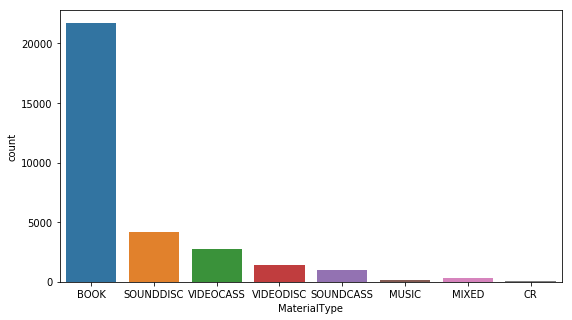

In [23]:
plt.figure(figsize=(9,5))
sns.countplot(mixdf['MaterialType'])

plt.show()

## TF-IDF


I'm now going to try to improve this feature, by using something called TF-IDF (term-frequency-inverse-document-frequency). This means that we weigh the terms by how uncommon they are, meaning that we care more about rare words existing in Text. 


In [24]:
tfidf = TfidfVectorizer(tokenizer=lambda x : x.split(), ngram_range=(1,3))

tfidf_mat = tfidf.fit_transform(new['Text'])

word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [31]:
print("Here aftre TF-IDF we have shape of Dataframe :  ",tfidf_mat.shape)

Here aftre TF-IDF we have shape of Dataframe :   (52755, 1069839)


Now here we will divide both Train and Test File again.
In which train_df include Target variable and test_df don''t have Traget variable.

In [32]:
train_df = tfidf_mat[:31653,]

test_df= tfidf_mat[31653:,]  

print("Shape of Test Dataframe :  ",train_df.shape)
print("Shape of Test Dataframe :  ",test_df.shape)

Shape of Test Dataframe :   (31653, 1069839)
Shape of Test Dataframe :   (21102, 1069839)


Spliting the dataframe into train for model creation and test dataframe to test the model performance. 

In [33]:
X_train,X_test, y_train, y_test = train_test_split(train_df, multilable_y, random_state = 0, test_size = 0.2)

print(X_train.shape ,X_test.shape, y_train.shape, y_test.shape)

(25322, 1069839) (6331, 1069839) (25322, 8) (6331, 8)


### Linear SVM with hyperparameter tuning

hyperparameter tunning for SGD classifier.

read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
------------------------------
default parameters
SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
class_weight=None, warm_start=False, average=False, n_iter=None)

some of methods
fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
predict(X)	Predict class labels for samples in X.


Here we are using L1 regulrization as we have so many variables to prevent overfitting

In [34]:
param_grid  = {"estimator__alpha": [ 10**-5.2, 10**-5.1,10**-4.9,10**-4.8]}

clf1 = OneVsRestClassifier(SGDClassifier(loss='hinge',penalty='l1'))

clf1 = GridSearchCV(clf1,param_grid, scoring = 'f1_micro', n_jobs=-1)


clf1.fit(X_train, y_train)

clf1_train_pred = clf1.predict(X_train)

clf1_test_pred = clf1.predict(X_test)




print("Here is the best value of alpha :  ",clf1.best_params_)

Here is the best value of alpha :   {'estimator__alpha': 1.584893192461114e-05}


In [35]:
print("Training Data micro f1 scoore :",metrics.f1_score(y_train, clf1.predict(X_train), average = 'micro'))

print("Testing Data micro f1 scoore :",metrics.f1_score(y_test, clf1.predict(X_test), average = 'micro'))

Training Data micro f1 scoore : 0.9061203319502075
Testing Data micro f1 scoore : 0.888959846731061


### Work on remaining features

Till now we have created model for only text data , So we have to include other variable to , So i am training a new model for remaining variable and then we will mearge both the model using STACKING techinuqe.

In [36]:
new.isna().sum()

Text                 0
word_count           0
unique_words         0
unique_percentage    0
w_notin_stop         0
Feature_4            0
Checkouts            0
dtype: int64

New dataframes (Train and Test) for remaining variables 

In [37]:
train_df_nfeatures =  new[:31653][['word_count','unique_words','unique_percentage','w_notin_stop','Feature_4','Checkouts']]

train_df_nfeatures.head()

,word_count,unique_words,unique_percentage,w_notin_stop,Feature_4,Checkouts
0,10,6,0.600000,10,0,1
1,9,9,1.000000,9,0,1
2,100,31,0.310000,94,6,3
3,67,18,0.268657,67,0,1
4,10,7,0.700000,7,4,1


In [38]:
print("Shape of train datframe of remaining variables :  ",train_df_nfeatures.shape)

Shape of train datframe of remaining variables :   (31653, 6)


In [39]:
test_df_nfeatures = new[31653:][['word_count','unique_words','unique_percentage','w_notin_stop','Feature_4','Checkouts']]

test_df_nfeatures.head()


,word_count,unique_words,unique_percentage,w_notin_stop,Feature_4,Checkouts
0,16,10,0.625000,12,4,1
1,21,12,0.571429,16,5,2
2,20,16,0.800000,20,0,2
3,26,16,0.615385,24,3,2
4,14,10,0.714286,12,2,2


In [40]:
print("Shape of train datframe of remaining variables :  ",test_df_nfeatures.shape)

Shape of train datframe of remaining variables :   (21102, 6)


Splitting data into train and test dataframe to Train model and to validate 

In [41]:

X_df_train,X_df_test, y_df_train,y_df_test = train_test_split(train_df_nfeatures, multilable_y, random_state=0, test_size = 0.2)

print(X_df_train.shape,X_df_test.shape, y_df_train.shape,y_df_test.shape)

(25322, 6) (6331, 6) (25322, 8) (6331, 8)


Here again we are using SGDclassifier where loss function will be Hinge loss from SVM.
 and we are using L2 Regularization to prevent overfitting.  

In [42]:
param_grid  = {"estimator__alpha": [0.001,0.001,0.01,0.1]}

clf2 = OneVsRestClassifier(SGDClassifier(loss='hinge',penalty='l2'))

clf2 = GridSearchCV(clf2,param_grid, scoring = 'f1_micro', n_jobs=-1)

clf2.fit(X_df_train, y_df_train)


clf2_train_pred = clf2.predict(X_df_train)

clf2_test_pred = clf2.predict(X_df_test)


In [43]:
print("Here is the best value of alpha :  ", clf2.best_params_)

Here is the best value of alpha :   {'estimator__alpha': 0.1}


In [44]:
print("Training Data micro f1 scoore :",metrics.f1_score(y_df_train, clf2.predict(X_df_train), average = 'micro'))

print("Testing Data micro f1 scoore :",metrics.f1_score(y_df_test, clf2.predict(X_df_test), average = 'micro'))

Training Data micro f1 scoore : 0.6644292414267889
Testing Data micro f1 scoore : 0.6672407853944196


# Stacking of both model

Here you can build multiple different learners and you use them to build an intermediate prediction, one prediction for each learned model. Then you add a new model which learns from the intermediate predictions the same target. This final model is said to be stacked on the top of the others, hence the name. Thus you might improve your overall performance, and often you end up with a model which is better than any individual intermediate model. 

In [45]:
print(clf1_train_pred.shape, clf2_train_pred.shape, clf1_test_pred.shape, clf2_test_pred.shape)

clf1_train_pred = pd.DataFrame(clf1_train_pred.toarray())
clf1_test_pred = pd.DataFrame(clf1_test_pred.toarray())
clf2_train_pred = pd.DataFrame(clf2_train_pred.toarray())
clf2_test_pred = pd.DataFrame(clf2_test_pred.toarray())

df_train = pd.concat([clf1_train_pred,clf2_train_pred], axis=1, sort=False)
df_test = pd.concat([clf1_test_pred,clf2_test_pred], axis=1, sort=False)

(25322, 8) (25322, 8) (6331, 8) (6331, 8)


### Stacking Model with hyperparameter tunning

In [46]:
param_grid  = {"estimator__alpha": [ 10**-4.5,10**-4,10**-3.9,10**3.8, 10**-3.55,10**-3.5,10**-3.4, 10**-1]}

stackclf = OneVsRestClassifier(SGDClassifier(loss='hinge',penalty='l1'))

stackclf = GridSearchCV(stackclf,param_grid, scoring = 'f1_micro', n_jobs=-1)


stackclf.fit(df_train, y_df_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          n_jobs=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'estimator__alpha': [3.1622776601683795e-05, 0.0001, 0.00012589254117941674, 6309.57344480193, 0.0002818382931264455, 0.00031622776601683794, 0.00039810717055349735, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [47]:
print("Here is the best value of alpha :  " , stackclf.best_params_)


Here is the best value of alpha :   {'estimator__alpha': 0.0001}


In [48]:
print("Training Data micro f1 scoore :",metrics.f1_score(y_df_train, stackclf.predict(df_train), average = 'micro'))

print("Testing Data micro f1 scoore :",metrics.f1_score(y_df_test, stackclf.predict(df_test), average = 'micro'))

Training Data micro f1 scoore : 0.9067018132438692
Testing Data micro f1 scoore : 0.8889953681520524


In [49]:
print("Training Data micro f1 scoore :",metrics.f1_score(y_df_train, stackclf.predict(df_train), average = 'micro'))

print("Testing Data micro f1 scoore :",metrics.f1_score(y_df_test, stackclf.predict(df_test), average = 'micro'))

Training Data micro f1 scoore : 0.9067018132438692
Testing Data micro f1 scoore : 0.8889953681520524


In [50]:
testpre = clf1.predict(test_df)

testpre_check = clf2.predict(test_df_nfeatures)

print(testpre.shape)
print(testpre_check.shape)

(21102, 8)
(21102, 8)


In [51]:
testpre = pd.DataFrame(testpre.toarray())
testpre_check = pd.DataFrame(testpre_check.toarray())


testdata = pd.concat([testpre,testpre_check], axis=1, sort=False)

test_prediction_final = stackclf.predict(testdata)

test_prediction_final.shape

(21102, 8)

In [52]:
test_prediction_final.toarray()[:8]

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [53]:
vectorizer.get_feature_names()

['book',
 'cr',
 'mixed',
 'music',
 'soundcass',
 'sounddisc',
 'videocass',
 'videodisc']

In [54]:
labels = ['BOOK','CR', 'MIXED', 'MUSIC', 'SOUNDCASS', 'SOUNDDISC','VIDEOCASS','VIDEODISC' ]

lab = [labels[test_prediction_final.toarray().argmax(axis=1)[i]] for i in range(len(test_prediction_final.toarray()))]

csvdf = pd.DataFrame(lab,columns=['MaterialType'], index= df2.ID)

csvdf.head(10)

,MaterialType
ID,
31654,BOOK
31655,VIDEOCASS
31656,SOUNDDISC
31657,BOOK
31658,BOOK
31659,BOOK
31660,SOUNDDISC
31661,BOOK
31662,BOOK


In [55]:
csvdf.to_csv("D:/Hacker earth/bf32d79c4a3711e9/Test/final_submission.csv")